In [1]:
# standard library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import sklearn.metrics
import sys
%matplotlib inline
import matplotlib.pyplot as plt

!pip show fairxplainer


from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils


import justicia.utils
from justicia.metrics import Metric


from data.objects.adult import Adult
from data.objects.ricci import Ricci
from data.objects.titanic import Titanic
from data.objects.compas import Compas
from data.objects.german import German


/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
verbose = False
dataset_name = "compas"
if(dataset_name == "adult"):
    dataset = Adult(verbose=verbose, config=2) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "ricci"):
    dataset = Ricci(verbose=verbose, config=0) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "titanic"):
    dataset = Titanic(verbose=verbose, config=2) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "compas"):
    dataset = Compas(verbose=verbose, config=1) # config defines configuration for sensitive groups
    df = dataset.get_df()
elif(dataset_name == "german"):
    dataset = German(verbose=verbose, config=2) # config defines configuration for sensitive groups
    df = dataset.get_df()
else:
    raise ValueError()


# get X,y
X = df.drop(['target'], axis=1)
y = df['target']

print(dataset.known_sensitive_attributes)
print(X.columns)

# one-hot encoding for categorical features (this takes care of Label encoding automatically)
X = utils.get_one_hot_encoded_df(X,dataset.categorical_attributes)

X.head(10)

['race']
Index(['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree'],
      dtype='object')


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,0,0.653846,0,0.0,0.000000,0.000000,0.000000,0
1,0,0.205128,0,0.0,0.000000,0.000000,0.000000,0
2,0,0.076923,0,0.0,0.000000,0.058824,0.105263,0
3,0,0.064103,0,0.0,0.076923,0.000000,0.026316,0
4,0,0.320513,0,0.0,0.000000,0.000000,0.052632,0
5,0,0.333333,0,0.0,0.000000,0.000000,0.000000,1
6,0,0.294872,1,0.0,0.000000,0.000000,0.368421,0
7,0,0.320513,0,0.0,0.000000,0.000000,0.078947,0
8,1,0.269231,1,0.0,0.000000,0.000000,0.000000,1
9,0,0.038462,1,0.0,0.000000,0.000000,0.026316,0


In [3]:
clf = LogisticRegression()
clf.fit(X, y)
print("\nTrain Accuracy:", sklearn.metrics.accuracy_score(clf.predict(X.values),y.values))


Train Accuracy: 0.6778486276684225


/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [4]:
metric = Metric(model=clf, 
                data=X, 
                sensitive_attributes=dataset.known_sensitive_attributes, 
                verbose=True, 
                encoding="best-correlated",
                dag_threshold=0.2)
metric.compute()
print("Sensitive attributes", metric.given_sensitive_attributes)
print("Disparate Impact:", metric.disparate_impact_ratio)
print("Statistical Parity:", metric.statistical_parity_difference)
print("Time taken", metric.time_taken, "seconds")

Learn-dependency encoding is solved based on Learn-efficient-dependency encoding
Expression:  -1 -1 -3 -5 -7 -9 -11 -14 -16 -18 0 0 1 1 2 3 4 4 5 6 0 0 0 1 1 1 2 2 2 0 1 2 3 4 5 7 8 9 1 5 8 11 15 18 22 25 29 -1 ?= 0
Translation accuracy 0.9067091766010535
Total number of variables in the formula: 48

---------------------------
Starting DAG learning
Maximum iteration 1  edges: 1 nodes 2
[('40', '39')]
Maximum iteration 5  edges: 5 nodes 7
[('2', '3'), ('4', '3'), ('5', '3'), ('40', '39'), ('41', '39')]
Maximum iteration 10  edges: 10 nodes 13
[('2', '3'), ('4', '3'), ('5', '3'), ('6', '3'), ('7', '3'), ('31', '30'), ('40', '39'), ('41', '39'), ('42', '39'), ('43', '39')]


============================== SubSet-Sum =============

Conditional relations {3: (2, 4, 5, 3), 39: (40, 41, 39)}
Chance variable [1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48]
Choice variabl

#### Most Favored group

race == 1


#### Least Favored group

race == 1


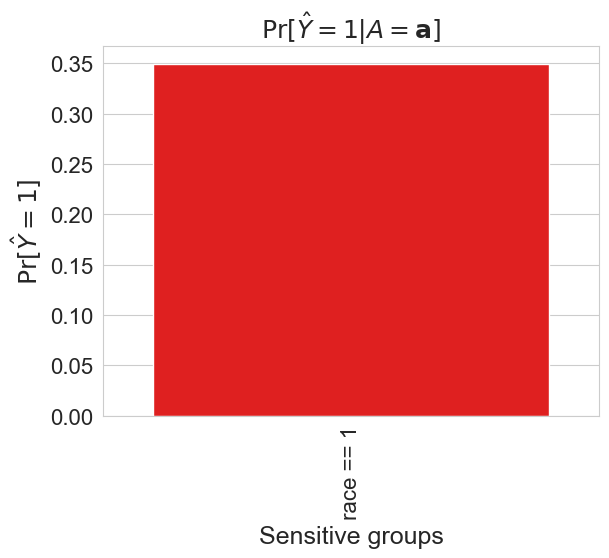

<Figure size 640x480 with 0 Axes>

In [5]:
import numpy as np
import seaborn as sns
from IPython.display import Markdown
groups = [(", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])])  for each_sensitive_attribute in group_info[0]]) for group_info in metric.sensitive_group_statistics]
PPVs = np.array([group_info[1] for group_info in metric.sensitive_group_statistics])

assert metric.disparate_impact_ratio == float(PPVs.min()/PPVs.max())
assert metric.statistical_parity_difference == PPVs.max() - PPVs.min()
display(Markdown("#### Most Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])]) for each_sensitive_attribute in list(metric.most_favored_group.items())]))
display(Markdown("#### Least Favored group"))
print((", ").join([" ".join([each_sensitive_attribute[0], each_sensitive_attribute[1][0], str(each_sensitive_attribute[1][1])]) for each_sensitive_attribute in list(metric.least_favored_group.items())]))

customize_color = {}
for idx, PPV in enumerate(PPVs):
    customize_color[groups[idx]] = "red" if PPV == PPVs.min() else ("green" if PPV ==PPVs.max() else "gray")
fontsize = 22
labelsize = 18

sns.set_style("whitegrid", {'axes.grid' : True})
sns.barplot(x=groups, y=PPVs, palette=customize_color)
plt.xticks(fontsize=labelsize-2, rotation=90)
plt.yticks(fontsize=labelsize-2)
plt.ylabel(r"$\Pr[\hat{Y} = 1]$", fontsize=labelsize)
plt.xlabel("Sensitive groups", fontsize=labelsize)
plt.title(r"$\Pr[\hat{Y} = 1 | A=\mathbf{a}]$", fontsize=labelsize)
plt.show()
plt.clf()

## Fairness explanation using (co)variance decomposition

In [6]:
fairXplainer = FairXplainer(clf, X, dataset.known_sensitive_attributes)
fairXplainer.compute(maxorder=2, spline_intervals=6, verbose=False)

### Individual FIFs

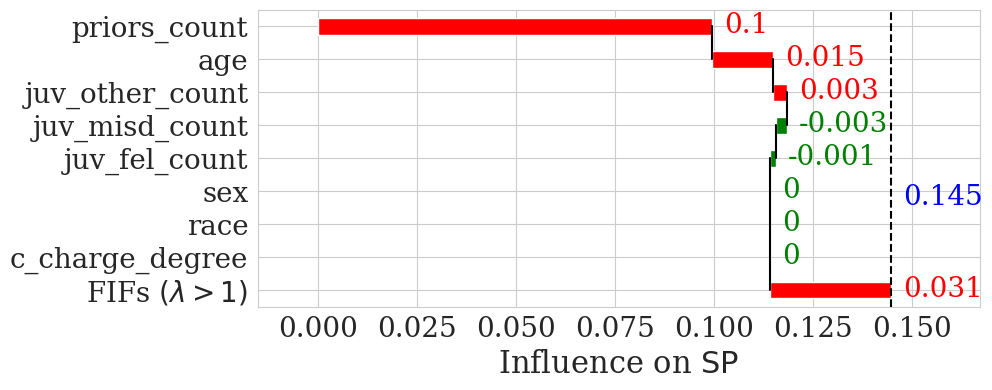

Exact statistical parity 0.1747909432721744


<Figure size 1000x400 with 0 Axes>

In [7]:
result = fairXplainer.get_weights()

fontsize = 22
labelsize = 20

plt = fif_plot(result, 
                draw_waterfall=True, 
                labelsize=labelsize, 
                figure_size=(10,4), 
                text_y_pad=0.2, 
                xlim=None, 
                result_y_location=0.6,
                x_label="Influence on " + r"$ \mathsf{SP} $"
            )
plt.show()
plt.clf()
print("Exact statistical parity", fairXplainer.statistical_parity_sample())

### Intersectional FIFs

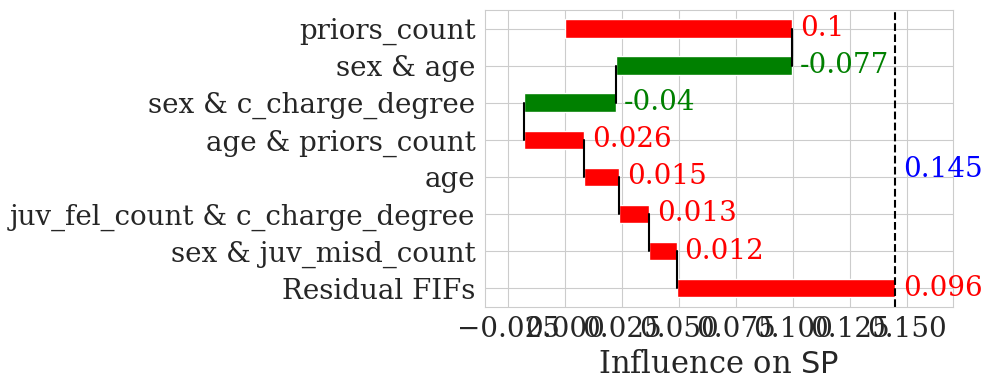

Exact statistical parity 0.1747909432721744


<Figure size 1000x400 with 0 Axes>

In [8]:
k = 7
result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(result, 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,4), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())